In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [ ]:
!pip install transformers sentencepiece

In [5]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [ ]:
header_name = ['TITLE', 'CATEGORY']
train = pd.read_csv("train.txt", header=None, sep='\t', names=header_name)
valid = pd.read_csv("valid.txt", header=None, sep='\t', names=header_name)
test = pd.read_csv("test.txt", header=None, sep='\t', names=header_name)

In [13]:
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_len):
        self.x = x  # Input data (titles)
        self.y = y  # Labels (categories)
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len  # Maximum length for padding

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Padding the sequences to max length
            truncation=True  # Truncate if sequence is longer than max length
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            "ids": torch.LongTensor(ids),
            "mask": torch.LongTensor(mask),
            "labels": torch.Tensor(self.y[idx])
        }

In [14]:
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

ids: tensor([  101,  8011,  4048, 15908,  2015,  9944, 12065,  2007,  6468,  3666,
         1002,  1015,  1012,  3486,  1024, 12731, 14343, 14767,   102,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
labels: tensor([1., 0., 0., 0.])


In [15]:
# Defining the BERT-based classification model
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # Pre-trained BERT model
        self.drop = torch.nn.Dropout(drop_rate)  # Dropout layer
        self.fc = torch.nn.Linear(768, output_size)  # Fully connected layer for classification

    def forward(self, ids, mask, return_dict):
        _, out = self.bert(ids, attention_mask=mask, return_dict=return_dict)
        out = self.fc(self.drop(out))
        return out

In [16]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()  # Set the model to evaluation mode
    loss = 0.0  # Initialize the loss to zero
    total = 0  # Initialize the total count to zero
    correct = 0  # Initialize the count of correct predictions to zero
    with torch.no_grad():  # Disable gradient calculations for inference
        for data in loader:  # Iterate through the data loader
            ids = data['ids'].to(device)  # Move input IDs to the specified device (CPU or GPU)
            mask = data['mask'].to(device)  # Move attention masks to the specified device
            labels = data['labels'].to(device)  # Move labels to the specified device

            outputs = model(ids, mask, return_dict=False)  # Get model outputs

            loss += criterion(outputs, labels).item()  # Accumulate the loss

            pred = torch.argmax(outputs, dim=-1).cpu().numpy()  # Get predicted class indices
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  # Get true class indices
            total += len(labels)  # Update the total count
            correct += (pred == labels).sum().item()  # Update the count of correct predictions

    return loss / len(loader), correct / total  # Return the average loss and accuracy


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)  # Move the model to the specified device

    # Create data loaders for training and validation datasets
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []  # log training loss and accuracy
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()  # Set the model to training mode
        for data in dataloader_train:  # Loop over the training batches
            ids = data['ids'].to(device)  # Move input IDs to the device
            mask = data['mask'].to(device)  # Move attention masks to the device
            labels = data['labels'].to(device)  # Move labels to the device

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(ids, mask, return_dict=False)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters

        # Calculate loss and accuracy for training and validation sets
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # Save the model checkpoint
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        # Print epoch statistics
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid} 

In [17]:
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

device = 'cuda' if cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

epoch: 1, loss_train: 0.0847, accuracy_train: 0.9543, loss_valid: 0.1189, accuracy_valid: 0.9250, 66.9090sec
epoch: 2, loss_train: 0.0445, accuracy_train: 0.9785, loss_valid: 0.1006, accuracy_valid: 0.9355, 67.2924sec
epoch: 3, loss_train: 0.0296, accuracy_train: 0.9861, loss_valid: 0.1055, accuracy_valid: 0.9348, 68.3072sec
epoch: 4, loss_train: 0.0218, accuracy_train: 0.9894, loss_valid: 0.1147, accuracy_valid: 0.9295, 72.5418sec


In [18]:
def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig("89.png")

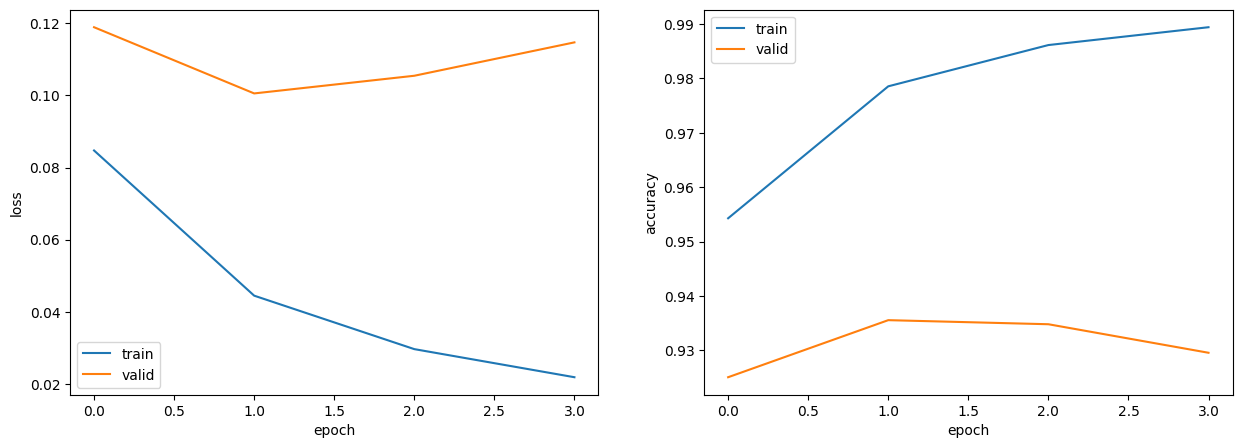

In [19]:
visualize_logs(log)

In [20]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, device):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)  # Create a data loader for the dataset

    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0 
    with torch.no_grad():  # Disable gradient calculations for inference
        for data in loader: 
            ids = data['ids'].to(device) 
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model.forward(ids, mask, return_dict=False)  # Get model outputs

            pred = torch.argmax(outputs, dim=-1).cpu().numpy()  # Get predicted class indices
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  # Get true class indices
            total += len(labels)  # Update the total count
            correct += (pred == labels).sum().item()  # Update the count of correct predictions

    return correct / total

In [21]:
print(f'accuracy (train): {calculate_accuracy(model, dataset_train, device):.3f}')
print(f'accuracy (valid): {calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'accuracy (test): {calculate_accuracy(model, dataset_test, device):.3f}')

accuracy (train)：0.989
accuracy (valid)：0.930
accuracy (test)：0.929
